In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Fitting an arbitrary function

Ok, as a proof of concept, in this notebook we'll generate a "smooth" function that we want to get back out. We'll then evaluate that function at many points along the x-axis and add noise to it. After that, we'll try to recover the original "smooth" function using a transdimensional algorithm.

# Generating fake data

Here I generate fake data using a random assortment of sines and cosines. The actual functional form doesn't matter...

In [2]:
# random sinusoids of different frequencies

Nfreqs = 3
maxfreq = 3

# list of frequencies
frequencies = np.linspace(0, maxfreq, num=Nfreqs)
# list of random phases between 0 and 2pi. Use
# random values drawn from [0,1] multiplied by 2pi
phases = np.random.rand(Nfreqs) * 2 * np.pi
amplitudes = np.random.rand(Nfreqs)

# make coefficients random, but then put them on roughly
# the same scale by dividing by dx^degres
def sinusoid(times, freq, phase, amplitude):
    return amplitude * np.sin(2 * np.pi * freq * times + phase)



def sum_of_sinusoids(xvals, freqs, phases, amplitudes):
    """evaluate a polynomial of degree (len(params) - 1) at xvalues     

    Args:
        xvals (numpy.ndarray): list of x-axis points at which to evaluate polynomail
        params (numpy.ndarray): list of polynomial coefficients (constant -> max degree)
    """
    # value of our curve
    yvals = np.zeros_like(xvals)
    
    for amp, freq, phase in zip(amplitudes, freqs, phases):
        yvals += sinusoid(xvals, freq, phase, amp)
        # print(coeff*xvals[-1]**ii)
    return yvals

# Statement of our problem

Let's now assume that we don't know what generated that strange looking curve, but we want to fit it. There's no obvious funcional form that the curve follows, but we're interested in (1) detecting whether it's there in the case where we have measurement noise (which I'll discuss in a moment), and (2) knowing the value of the curve at each point, if we can. 

So let's treat this like a "real" situation. We have a "detector" and we measure our curve at many points on the x-axis. At each one of those points we have measurement noise, because our detector isn't perfect. So at each point on the x-axis where we make a measurement, we get something "away" from the "true" curve, and how far away is *random*. So we may not know what the measurement noise is (i.e. how far we are from the "true" curve when we take our measurement), but we will assume for now that we do know the *statistics* of the measurement noise. 

Specifically, we will assume that the measurement noise is "zero mean" -- meaning that our measurement noise will randomly push us above or below the "true" curve when we make a measurement, but *on average* we are not systematically being pushed preferentially above or below. We also assume that the measurement noise follows a *Gaussian distribution*, and that the *standard deviation* of the measurement noise is known (for the stochastic background searches, this is generally the case). 

## Measurement noise
The measurement noise is drawn from a Gaussian distribution. That is, at each point there's some "randomness" added to the true signal. If we take that randomness at each point and create a histogram, that histogram will look like a Gaussian (or normal) distribution.


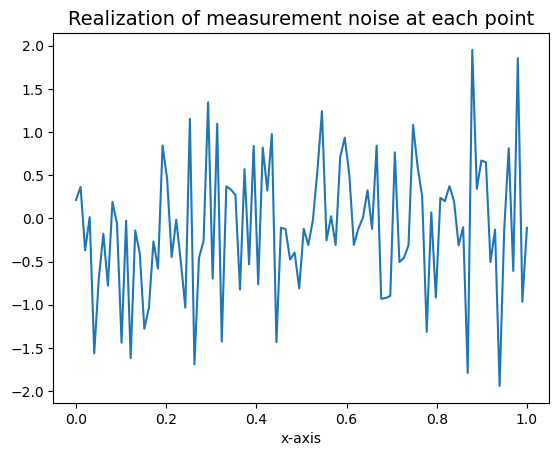

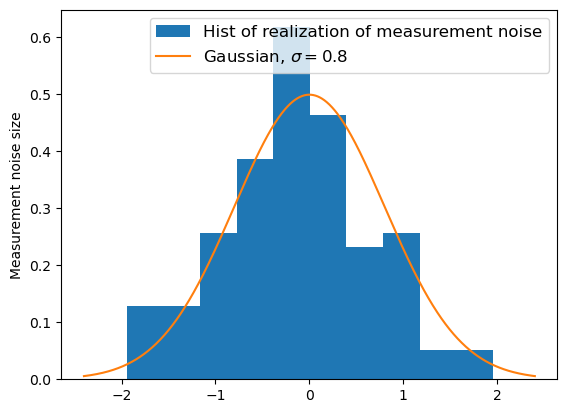

In [3]:
measurement_noise_standard_deviation = 0.8
xvals = np.linspace(0, 1, num=100)
# measurement noise at each point, using random number generator
measurement_noise = measurement_noise_standard_deviation * np.random.randn(xvals.size) 
plt.plot(xvals, measurement_noise)
plt.xlabel('x-axis')
plt.title("Realization of measurement noise at each point", fontsize=14)
plt.show()

# import a class that calculates Normal (Gaussian) distribution
# information for us
from scipy.stats import norm

#histogram this measurement noise to show it follows a Gaussian
plt.hist(measurement_noise, density=True, label='Hist of realization of measurement noise')
# compare to 
possible_noise_values = np.linspace(-3, 3, num=1000) * measurement_noise_standard_deviation
plt.plot(possible_noise_values, norm.pdf(possible_noise_values, scale=measurement_noise_standard_deviation),
         label=f'Gaussian, $\\sigma={measurement_noise_standard_deviation}$')
plt.ylabel('Measurement noise size')
plt.legend(fontsize=12)
plt.show()

## Now let's create a noisy data set

Below we add together the "true" signal (our wiggly line) with the measurement noise. We assume that we know the standard deviation of the measurement noise (usually we have some idea of what this is), so when we plot the data, we can use that as our uncertainty on each measurement.

## generate the fake data with measurement noise (which we'll assume is known for now)

In [4]:

measurement_noise_standard_deviation = 0.8

# measurement noise at each point, using random number generator
measurement_noise = measurement_noise_standard_deviation * np.random.randn(xvals.size) 
true_signal = sum_of_sinusoids(xvals, frequencies, phases, amplitudes)
realistic_data = true_signal + measurement_noise

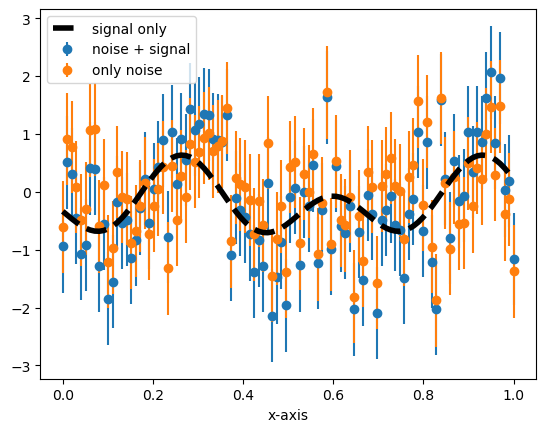

In [5]:
plt.errorbar(xvals, realistic_data, label='noise + signal', yerr=measurement_noise_standard_deviation, fmt='o', zorder=-1)
plt.errorbar(xvals, measurement_noise, label='only noise', yerr=measurement_noise_standard_deviation, fmt='o', zorder=-1)
plt.plot(xvals, true_signal, label='signal only', c='k', ls='--', lw=4)
plt.legend()
plt.xlabel('x-axis')
plt.show()

# Fitting this curve

This curve is "weird", and we'd like to know what its value is at each point. But we'd also like to know whether there's a curve there at all, or just noise. For example, we've made the noise large enough that one could ask "is it obvious that the blue lines have some signal in them? Or are the blue points consistent with what we'd expect from only measurement noise". 

So we have two problems we want to tackle. This notebook just deals with the first -- **what is our estimate of the signal at each point on the x-axis, if all we have are the blue points?**

We'll start with splines.

# Spline interpolation

We want to know the value of our wiggly curve at each point. We could just use the estimate from our data points. But if we have lots of noise and we know, or assume, that our wiggly curve is "smooth" on some length scales, then it may make more sense to evaluate it at a few points on the x-axis, and then "smoothly" interpolate between them. So that's what we'll do here. We'll pick 10 points along the x-axis at which we'll try to estimate the actual value of our curve. And then we'll interpolate between those points using "cubic splines" (which we don't need to know the specifics of right now).

Our method roughly works as follows:

    * We will generate a model by placing "a few" points in the x-y plane and interpolating between them using "cubic spline interpolation".
    * The x-values won't change for now, but the y-values at each point will be "free parameters" that we will try to fit for.
    * Once we set the x-values, and choose the y-values for one "guess" we use cubic spline interpolation to estimate our "generic model" at each point where we have data.
    * We then *quantitatively* comopare that model with our data, using information about both the model and our data.

So to start, let's choose 10 x-values randomly spaced. These won't change, and we will be interpolating between these points using "cubic splines". The $y$-values of these points will be the "free parameters" of our model. That is, these are the things that can change to try to make our fit "better" (and here "better" will have a specific, qualitative meaning).

In [6]:
N_spline_points = 20
x_spline_points = np.linspace(xvals[0], xvals[-1], num=N_spline_points)


Now, let's make a random "guess" as to the y-value at each of those x-values. These are known as our "spline control points". Reading off our plot above, the y-values might vary between -3 and 3, so let's pick random y-values between there. We'll then plot our spline control points on the same plot as above.

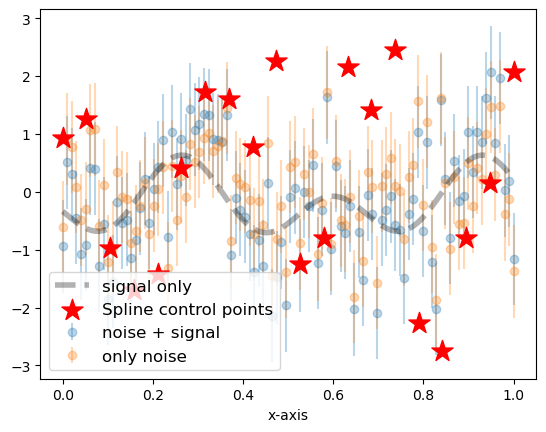

In [7]:
# pick values between -3 and 3. So the width of our interval is 6 and the lowest
# value is -3. np.random.randn generate values between [0, 1] so to map that to our interval
# we first transform [0, 1] -> [0, 6] by multiplication, then [0, 6] -> [-3, 3] by subtracting

y_spline_points = np.random.rand(N_spline_points) * 6 - 3

plt.errorbar(xvals, realistic_data, label='noise + signal', yerr=measurement_noise_standard_deviation, fmt='o', zorder=-1, alpha=0.3)
plt.errorbar(xvals, measurement_noise, label='only noise', yerr=measurement_noise_standard_deviation, fmt='o', zorder=-1, alpha=0.3)
plt.plot(xvals, true_signal, label='signal only', c='k', ls='--', lw=4, alpha=0.3)
plt.scatter(x_spline_points, y_spline_points, s=256, c='r', marker='*', label='Spline control points')
plt.legend(fontsize=12)
plt.xlabel('x-axis')
plt.show()

Now that we've set our control points, which if we made a good guess (we didn't....) should sit near the black curve, we interpolate between these red points to generate our "full model" at every xvalue. The code snippet below does that.

In [8]:
# this creates a function, "our_model" and when we do our_model(xvals) we'll get out the yvalues of our new model
our_model_cubic_splines = CubicSpline(x_spline_points, y_spline_points)
cubic_spline_model_y_values = our_model_cubic_splines(xvals)

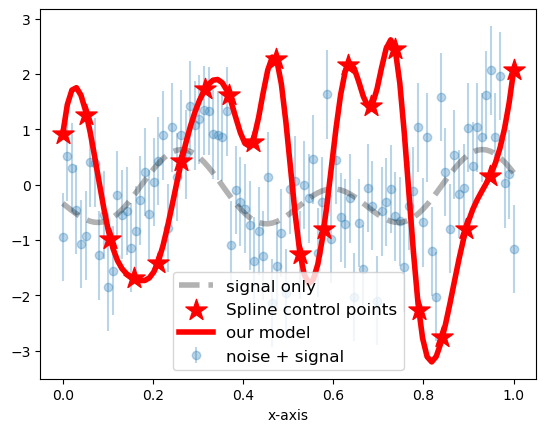

In [9]:
plt.errorbar(xvals, realistic_data, label='noise + signal', yerr=measurement_noise_standard_deviation, fmt='o', zorder=-1, alpha=0.3)
# plt.errorbar(xvals, measurement_noise, label='only noise', yerr=measurement_noise_standard_deviation, fmt='o', zorder=-1, alpha=0.3)
plt.plot(xvals, true_signal, label='signal only', c='k', ls='--', lw=4, alpha=0.3)
plt.scatter(x_spline_points, y_spline_points, s=256, c='r', marker='*', label='Spline control points')
plt.plot(xvals, cubic_spline_model_y_values, c='r', lw=4, label='our model')
plt.legend(fontsize=12)
plt.xlabel('x-axis')
plt.show()

## Instead of splines...
We can use any "interpolating" model. Basically any function you want to interpolate between these points. Some other good options:

1. "Linear interpolation in log-space." That is, you take the log of the x- and y-values and then do linear interpolation. This is equivalent to fitting a "piece-wise power law" model in regular x- and y-space.
2. "Akima splines" -- akima splines are less "smooth" than cubic splines and suffer less from edge effects and generally wiggle less.
3. "Cubic splines in log-space" The same as (1) but in log-space you use cubic splines. Using log-space has an added benefit -- if your function never goes negative (and you know it) then fitting in log-space will guarantee that your model never goes negative as well.

Back to the plot above. That's not a great fit. The red clearly does not agree with the black.  We said we know that our *measurement noise* is (1) Drawn from a Gaussian distribution and (2) has zero-mean and a known standard deviation $\sigma$. So if the red curve is a good approximation to the black curve, then when we subtract the two we should get back something that has the properties of our Measurement noise -- that is, Gaussian, zero mean, and standard deviation of $\sigma$!

So let's quantify this. We start by considering our "residual". Let's call $x$ our data and $m$ our model. Then $r = x-m$ should be *gaussian distributed* with zero mean. The probability of getting an individual data point $x_i$ *given* our model parameters (i.e. where we placed our red stars), and that the measurement noise has standard deviation $\sigma$ is given by:

$$p(x_i | \textrm{params}) = \frac{\exp\left(-\frac{(x_i - m_i)^2}{2\sigma^2} \right)}{\sqrt{2 \pi \sigma^2}} = \frac{\exp\left(-\frac{r_i^2}{2\sigma^2} \right)}{\sqrt{2 \pi \sigma^2}}.$$

This is what we typically use for LIGO data analysis (and lots of data analysis across astronomy and astrophysics).

So we want our residuals $r_i$ to have the properties of our measurement noise. This hopefully makes intuitive sense! Once we subtract off the signal (which we do with $x_i - m_i$), all that should be left is noise.

 When we have many measurements at different points, we will assume that these measurements are *independent* of each other (which for the SGWB case is a good assumption). So this says that for a set of measurements $\{x\}$, we can just multiplie their probabilities to gether:

\begin{align}
 p(\{x\} | \textrm{params}) &= \frac{\exp\left(-\frac{(x_1 - m_1)^2}{2\sigma^2} \right)}{\sqrt{2 \pi \sigma^2}} \times \frac{\exp\left(-\frac{(x_2 - m_2)^2}{2\sigma^2} \right)}{\sqrt{2 \pi \sigma^2}} \times \ldots \times \frac{\exp\left(-\frac{(x_N - m_N)^2}{2\sigma^2} \right)}{\sqrt{2 \pi \sigma^2}} \\
  &=\prod_{i=1}^{i=N} \frac{\exp\left(-\frac{(x_i - m_i)^2}{2\sigma^2} \right)}{\sqrt{2 \pi \sigma^2}}.
 \end{align}

Note that "params" here refers to where we place those red stars. We want to *maximize* this probability over those parameters. That is, we want to know, for what values of our model parameters does $r$ look *most like a gaussian variable*. Normally, we acutally work with the natural log of the probability. In that case, our product becomes a sum:

 \begin{align}
 \ln p(\{x\} | \textrm{params}) &= \sum_{i=1}^{i=N} -\frac{(x_i - m_i)^2}{2\sigma^2} - \frac{1}{2}\ln(2\pi \sigma^2).
 \end{align}
 
 
 Maximizing the natural log should give the same result as mazimizing the full function. We can do this maximization quite a few different ways. One of them is using "Markov chain Monte Carlo," which we will eventually discuss. But here I'll do something similar. First, I'll start by making a slightly better guess as to where we place our red points. Then I will use a simple minimization tool from scipy. `scipy` actually has *minization* tools. So we will minimize the negative of the above function.

 ### Code to make a better guess

 The code in the next cell is to make a better guess for the starting point of our parameters. Which in this case will just be the value of our measurement at those $x$-values.

In [10]:
# "quick and dirty" guess for our model
measured_xval_indexes_closest_to_spline_control_points = np.array([np.argmin(np.abs(xvals - x_spline_points[ii])) for ii in range(x_spline_points.size)])
yval_control_starting_point = realistic_data[measured_xval_indexes_closest_to_spline_control_points]

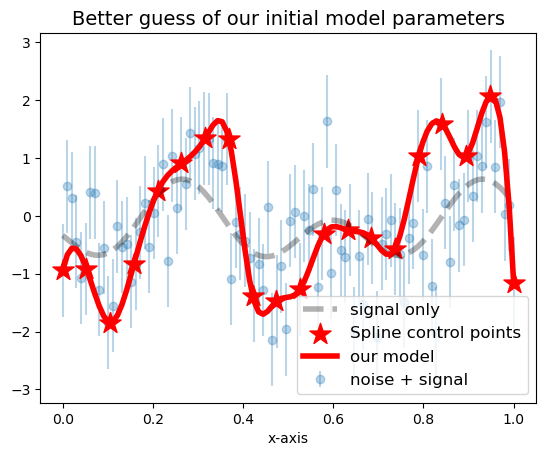

In [11]:
plt.errorbar(xvals, realistic_data, label='noise + signal', yerr=measurement_noise_standard_deviation, fmt='o', zorder=-1, alpha=0.3)
# plt.errorbar(xvals, measurement_noise, label='only noise', yerr=measurement_noise_standard_deviation, fmt='o', zorder=-1, alpha=0.3)
plt.plot(xvals, true_signal, label='signal only', c='k', ls='--', lw=4, alpha=0.3)
plt.scatter(x_spline_points, yval_control_starting_point, s=256, c='r', marker='*', label='Spline control points')
our_new_model = CubicSpline(x_spline_points, yval_control_starting_point)
plt.plot(xvals, our_new_model(xvals), c='r', lw=4, label='our model')
plt.legend(fontsize=12)
plt.title("Better guess of our initial model parameters", fontsize=14)
plt.xlabel('x-axis')
plt.show()

### Define our likelihood function

In the next cell we define our log likelihood function. `norm.logpdf` just calculates the natural log of the probability discussed above. `scale` refers specifically to the standard deviation $\sigma$ in that equation, which we will assume we know. We then take the negative of that function, since we will use a `minimization` function instead of a `maximization` function (which is what `scipy` prefers).

In [12]:
def loglike(params):
    our_model = CubicSpline(x_spline_points, params)
    # this evaluates the equation ln(p(x) | parameters) = ... a few cells above.
    return np.sum(norm.logpdf(realistic_data - our_model(xvals), scale=measurement_noise_standard_deviation))

# scipy prefers to minimize things instead of maximize things
def neg_ll(params):
    return -loglike(params)
import scipy.optimize as so

In [13]:
out = so.minimize(neg_ll, yval_control_starting_point)

(100, 1000)


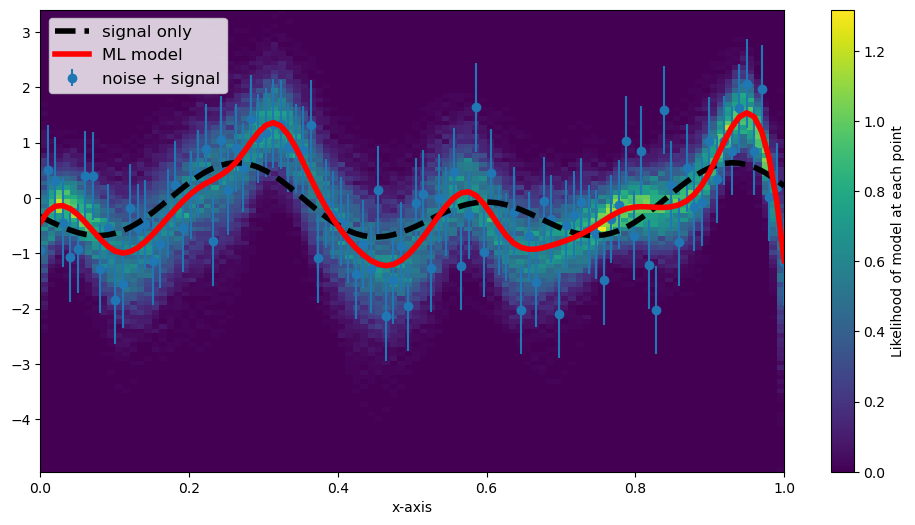

In [14]:
# "quick and dirty" guess for our model
plt.figure(figsize=(12,6))
plt.errorbar(xvals, realistic_data, label='noise + signal', yerr=measurement_noise_standard_deviation, fmt='o', zorder=-1)
# plt.errorbar(xvals, measurement_noise, label='only noise', yerr=measurement_noise_standard_deviation, fmt='o', zorder=-1, alpha=0.3)
plt.plot(xvals, true_signal, label='signal only', c='k', ls='--', lw=4)
# plt.scatter(x_spline_points, out.x, s=256, c='r', marker='*', label='Spline control points')
final_vals = np.zeros((xvals.size, 1000))
myvals = np.random.multivariate_normal(out.x, out.hess_inv, size=1000)
xval_mesh = np.zeros_like(final_vals)
for ii in range(1000):
    our_ml_model = CubicSpline(x_spline_points, myvals[ii],)
    final_vals[:, ii] = our_ml_model(xvals)
    xval_mesh[:, ii] = xvals
    # plt.plot(xvals, our_ml_model(xvals), c='g', lw=2, alpha=0.1, zorder=-100)
print(xval_mesh.shape)
plt.hist2d(xval_mesh.flatten(), final_vals.flatten(), bins=100, density=True, zorder=-2)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Likelihood of model at each point')
our_ml_model = CubicSpline(x_spline_points, out.x)   
plt.plot(xvals, our_ml_model(xvals), c='r', lw=4, label='ML model')
plt.legend(fontsize=12)
plt.xlabel('x-axis')
plt.show()


# Using the new code

Ok, above we showed how to get a ML model using *all* of the spline points we started with. And these are the start heights we put into the sampler.

To use the new code, we have to create two small classes. A "data" class that handles the data,
and a new class that "subclasses" `BaseSplineModel` and implements a likelihood that uses that data class.

I did it this way because the data may not be in the form of something that can be fit by a spline...it could be that there's something that can be fit by a spline that gets mapped onto the data. So the likelihood and how it uses the spline model, as well as the form of the actual data, can be specified by the user. Below is code showing you how to do this for the simplest case, which is what we have above in this notebook. I think these

In [15]:
from transdimensional_spline_fitting import BaseSplineModel
class SmoothCurveDataObj(object):
    """
    A data class that can be used with our spline model
    """
    def __init__(self, data_xvals, data_yvals, data_errors):
        self.data_xvals = data_xvals
        self.data_yvals = data_yvals
        self.data_errors = data_errors

class FitSmoothCurveModel(BaseSplineModel):
    """
    Example of subclassing `BaseSplineModel` to create a likelihood
    that can then be used for sampling.

    Assumes use with `ArbitraryCurveDataObj`

    You also need to create a simple data class to go along with this. This
    allows the sampler to be used with arbitrary forms of data...
    """
    def ln_likelihood(self, config, heights):
        """
        Simple Gaussian log likelihood where the data are just simply
        points in 2D space that we're trying to fit.

        This could be something more complicated, though, of course. For example,
        You might create your model from the splines (`model`, below) and then use that
        in some other calculation to put it into the space for the data you have.

        :param data_obj: `ArbtraryCurveDataObj` -- an instance of the data object class associated with this likelihood.
        :return: log likelihood
        """
        # be careful of `evaluate_interp_model` function! it does require you to give a list of xvalues,
        # which don't exist in the base class!
        model = self.evaluate_interp_model(self.data.data_xvals, heights, config)
        return np.sum(norm.logpdf(model - self.data.data_yvals, scale=self.data.data_errors))

In [16]:
data = SmoothCurveDataObj(xvals, realistic_data, measurement_noise_standard_deviation*np.ones(xvals.size))

In [17]:
curve_model = FitSmoothCurveModel(data, 20, (xvals[0], xvals[-1]), (-4, 4))

# Perform a prior test

Here we check out sampler quickly. We don't sample the likelihood, we just sample the prior.


In [19]:
results = curve_model.sample(100_000, prior_test=True, proposal_weights=[1, 1, 1, 1], start_heights=out.x)

100%|████████████████████████████████| 100000/100000 [00:16<00:00, 6039.57it/s]


In [20]:
Nvals = np.sum(results.configurations, axis=1)
Nvals.shape

(100000,)

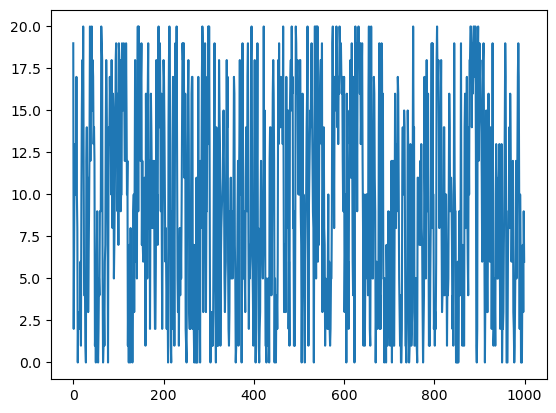

In [21]:
plt.plot(Nvals[::100])

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5]


(array([485., 513., 454., 461., 466., 445., 488., 446., 424., 469., 430.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5]),
 <BarContainer object of 11 artists>)

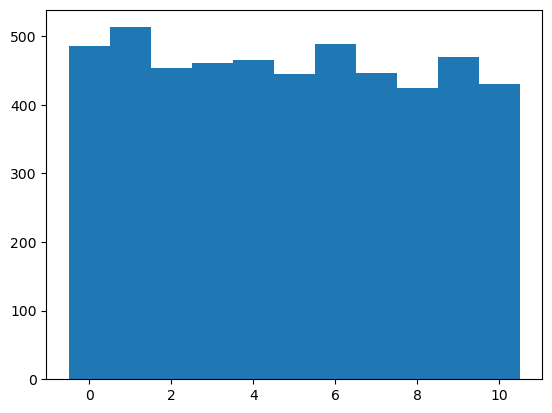

In [22]:
bins = np.linspace(-0.5, 10.5, num=12)
print(bins)
plt.hist(Nvals[10_000::10], bins=bins)

# Now let's do it for real...

In [23]:
data = SmoothCurveDataObj(xvals, realistic_data, measurement_noise_standard_deviation*np.ones(xvals.size))
curve_model = FitSmoothCurveModel(data, 20, (xvals[0], xvals[-1]), (-4, 4), interp_type='cubic')

In [24]:
curve_model.N_possible_knots

20

In [25]:
results = curve_model.sample(100_000, prior_test=False, proposal_weights=[1, 1, 1, 1], start_heights=out.x)

100%|████████████████████████████████| 100000/100000 [00:26<00:00, 3801.88it/s]


In [26]:
curve_model.N_possible_knots

20

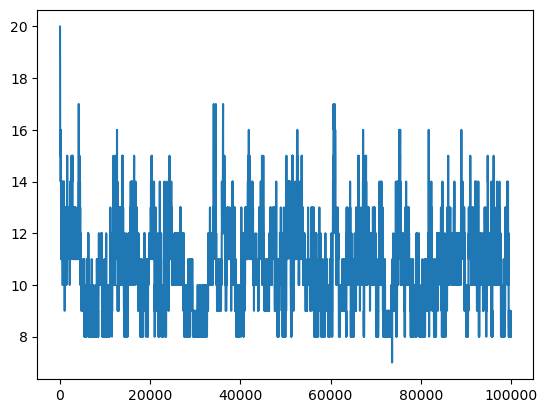

In [27]:
Nvals = np.sum(results.configurations, axis=1)
plt.plot(Nvals)

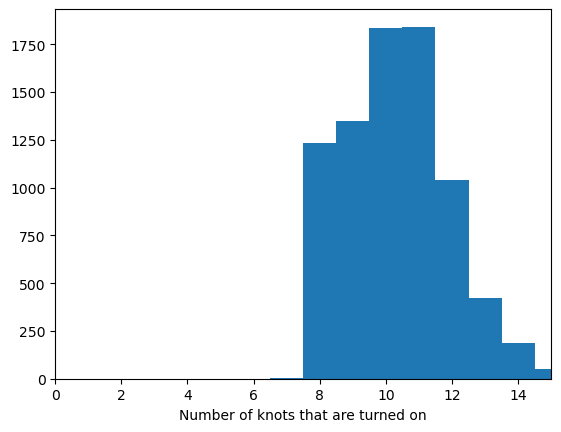

In [28]:
# make sure each bin has one integer...
bins = np.linspace(-0.5, 50.5, num=52)

plt.hist(Nvals[20_000::10], bins=bins)
plt.xlim(0, 15)
plt.xlabel("Number of knots that are turned on")
plt.show()

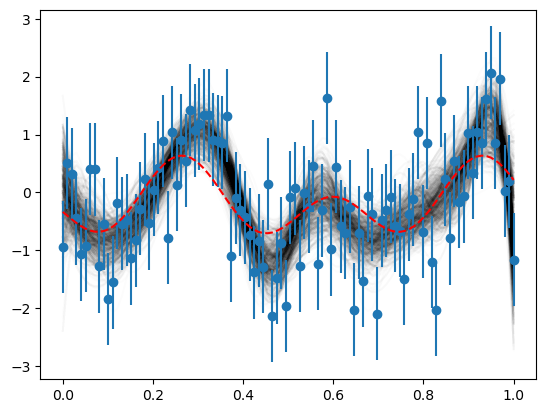

In [29]:
for ii in range(1000):
    idx = np.random.choice(np.arange(50_000))
    new_xvals = np.linspace(0, 1, num=100)
    plt.plot(xvals, curve_model.evaluate_interp_model(new_xvals, results.heights[idx+20_000], results.configurations[idx+20_000].astype(bool)), alpha=0.01, c='k')
plt.errorbar(xvals, realistic_data, yerr=measurement_noise_standard_deviation, c='C0', fmt='o', alpha=1, label='Data', zorder=1000)
plt.plot(xvals, true_signal, c='r', ls='--', label='True signal', zorder=1001)
plt.show()
             